# Wild Flower Classification Project 3 - season2 Last 3 blocks (FINAL)

### Wild Flower Classification using Transfer Learning 3 season2 - Last 3 blocks

This is taken from `wildflower_classifier3.ipynb` for season 2 (Refined data version)

- Using InceptionV3 + `tf.keras.applications.inception_v3.preprocess_input` instead of `rescale = 1./255`
- weight decay : 0.0001 -> 0.00001  ===> Same weight decay as classifier2. (= 0.0001)
- **Fine tune last 3 Inception Modules**

**NOTE:**
This notebook is for the **final** evaluation of the model perfomance.
- Remove the randomness of parameters to compare the pure defferences of performance between models.

**REFERENCE**
- [How to Get Reproducible Results with Keras](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)
- [How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

### Set random seeds for Pypthon random, Numpy random, and TensorFlow random.

In [1]:
import os

In [2]:
SEED_VALUE = 47

In [3]:
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)

In [4]:
import random
random.seed(SEED_VALUE)

In [5]:
import numpy as np
np.random.seed(SEED_VALUE)

In [6]:
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

### To remove randomness produced by GPU, use CPU.

In [7]:
# If I want to use CPU not GPU intentionally, execute this block.

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
%matplotlib notebook
%load_ext tensorboard

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
#import numpy as np
#import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [9]:
#from centerLoss import prelu, zero_loss, my_model
#from centerLoss import CenterLossLayer
#from utils import tbProjector, PCAPlotter, create_testdata

In [10]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [11]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [12]:
image_dir = "wf_data2"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

wf_data2/train
items = 108


In [13]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 4853
class_list[:10] = ['Actinotus_helianthi', 'Alyogyne_huegelii', 'Anthocercis_littorea', 'Anthocercis_viscosa', 'Banksia', 'Beaufortia_squarrosa', 'Blandfordia_grandiflora', 'Bossiaea_aquifolium_', 'Bossiaea_eriocarpa', 'Burchardia_congesta']


In [14]:
_BATCH_SIZE = 32

## Inspect training dataset

In [15]:
def plot_dataset(image_samples, name_list):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5, figsize=(9, 5) )
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
 
            img = tf.keras.preprocessing.image.load_img(image_samples[count])
            img = tf.keras.preprocessing.image.img_to_array(img)
            img /= 255.
            axs[i, j].imshow(img)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_title(name_list[count], fontdict={'fontsize' : 'small'})
            count+=1
        #plt.title(examples[1][i])
    plt.show()

<IPython.core.display.Javascript object>


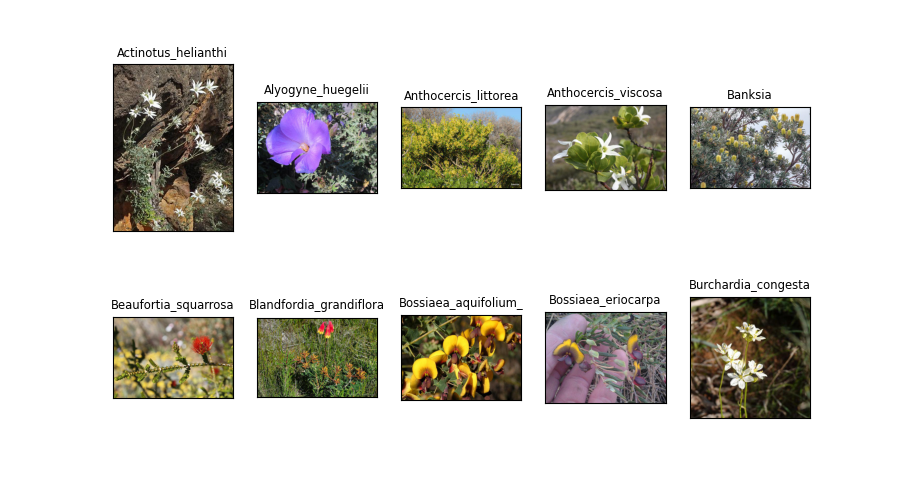

In [16]:
show_plot_num = 10

plot_list = []
for i, cls in enumerate(class_list):
    if i >= show_plot_num:
        break
        
    cls_path = os.path.join(train_dir, cls)
    imlist = os.listdir(cls_path)
    plot_list.append(os.path.join(cls_path, imlist[0]))
    
#print(plot_list)
#print(class_list[:show_plot_num])
plot_dataset(plot_list, class_list[:show_plot_num])

## Setup train data generator

In [17]:
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    #zoom_range=0.1,
    rotation_range=20,
    horizontal_flip=True,   
    #rescale=1./255
    preprocessing_function=keras.applications.inception_v3.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 4853 images belonging to 108 classes.


## Setup validation data generator

In [18]:
valid_dir = os.path.join(image_dir, "valid")

all_images_valid = 0

for cl in class_list:
    all_images_valid += len(os.listdir(os.path.join(valid_dir, cl)))

print("All image files in validation = {}".format(all_images_valid))
#print("class_list[:10] = {}".format(class_list[:10]))

All image files in validation = 605


In [19]:
#valid_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(image_dir, "valid"),
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 605 images belonging to 108 classes.


## Load a pre-trained model and attach some fully-connected layers

In [20]:
weight_decay = 0.0001

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

#x = base_model(img_input, training=False)
x = base_model(img_input)
#x = keras.layers.Flatten()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
out = keras.layers.Dense(train_classnum, activation='softmax', name='output', kernel_regularizer=l2(weight_decay))(x)
#out = keras.layers.Dense(train_classnum, activation='softmax', name='output')(x)

model = keras.Model(inputs=img_input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328

## compile

In [21]:
#initial_learning_rate = 0.001

optim = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim,
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [22]:
epochs = 100
steps_per_epoch = int(all_images/_BATCH_SIZE)
val_steps = int(all_images_valid/_BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=val_steps
)

Epoch 1/100
151/151 [==============================] - 137s 910ms/step - loss: 4.5861 - accuracy: 0.0333 - val_loss: 3.9622 - val_accuracy: 0.1076
Epoch 2/100
151/151 [==============================] - 166s 1s/step - loss: 3.7474 - accuracy: 0.1255 - val_loss: 3.1287 - val_accuracy: 0.2378
Epoch 3/100
151/151 [==============================] - 164s 1s/step - loss: 3.2644 - accuracy: 0.1829 - val_loss: 2.7429 - val_accuracy: 0.3090
Epoch 4/100
151/151 [==============================] - 161s 1s/step - loss: 2.9928 - accuracy: 0.2431 - val_loss: 2.5064 - val_accuracy: 0.3542
Epoch 5/100
151/151 [==============================] - 162s 1s/step - loss: 2.7926 - accuracy: 0.2788 - val_loss: 2.4130 - val_accuracy: 0.3611
Epoch 6/100
151/151 [==============================] - 162s 1s/step - loss: 2.7090 - accuracy: 0.2997 - val_loss: 2.3143 - val_accuracy: 0.3854
Epoch 7/100
151/151 [==============================] - 163s 1s/step - loss: 2.5528 - accuracy: 0.3159 - val_loss: 2.2070 - val_accura

151/151 [==============================] - 160s 1s/step - loss: 1.7218 - accuracy: 0.5235 - val_loss: 1.6899 - val_accuracy: 0.5330
Epoch 58/100
151/151 [==============================] - 161s 1s/step - loss: 1.7445 - accuracy: 0.5254 - val_loss: 1.7255 - val_accuracy: 0.5399
Epoch 59/100
151/151 [==============================] - 161s 1s/step - loss: 1.7146 - accuracy: 0.5285 - val_loss: 1.7372 - val_accuracy: 0.5451
Epoch 60/100
151/151 [==============================] - 160s 1s/step - loss: 1.7307 - accuracy: 0.5252 - val_loss: 1.7256 - val_accuracy: 0.5226
Epoch 61/100
151/151 [==============================] - 161s 1s/step - loss: 1.6785 - accuracy: 0.5432 - val_loss: 1.6887 - val_accuracy: 0.5608
Epoch 62/100
151/151 [==============================] - 161s 1s/step - loss: 1.7272 - accuracy: 0.5258 - val_loss: 1.7104 - val_accuracy: 0.5503
Epoch 63/100
151/151 [==============================] - 161s 1s/step - loss: 1.6643 - accuracy: 0.5410 - val_loss: 1.7187 - val_accuracy: 0.517

In [23]:
#model_file = "wfmodel_noft_" + str(epoch_time) + ".h5"
model_file = "wfmodel3_s2_3b_noft_final" + ".h5"
model.save(model_file)
print("Trained model was saved into {}.".format(model_file))

Trained model was saved into wfmodel3_s2_3b_noft_final.h5.


## Fine Tuning

In [24]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [25]:
base_model.trainable = True

In [26]:
# Train last 3 inception blocks (from 229 - )
# right after the concatenate layer which has auxilialy classifier. 
for layer in base_model.layers[:229]:
    layer.trainable = False
    
for layer in base_model.layers[229:]:
    layer.trainable = True
    

In [27]:
#base_model.summary()

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328

In [29]:
#base_model.trainable = True

optim_ft = optimizers.Adam(learning_rate=1e-5)
#optim_ft = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optim_ft,
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [30]:
ft_epochs = 100
#ft_steps_per_epoch = int(all_images/_BATCH_SIZE)
#ft_val_steps = int(all_images_valid/_BATCH_SIZE)

history_ft = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=ft_epochs,
    validation_data=valid_generator,
    validation_steps=val_steps
)

Epoch 1/100
151/151 [==============================] - 231s 2s/step - loss: 3.0339 - accuracy: 0.2763 - val_loss: 2.0035 - val_accuracy: 0.4896
Epoch 2/100
151/151 [==============================] - 229s 2s/step - loss: 2.5651 - accuracy: 0.3559 - val_loss: 2.0488 - val_accuracy: 0.4688
Epoch 3/100
151/151 [==============================] - 231s 2s/step - loss: 2.3076 - accuracy: 0.4086 - val_loss: 1.9337 - val_accuracy: 0.5000
Epoch 4/100
151/151 [==============================] - 227s 2s/step - loss: 2.1199 - accuracy: 0.4468 - val_loss: 1.8494 - val_accuracy: 0.5017
Epoch 5/100
151/151 [==============================] - 231s 2s/step - loss: 1.9856 - accuracy: 0.4624 - val_loss: 1.8004 - val_accuracy: 0.5191
Epoch 6/100
151/151 [==============================] - 231s 2s/step - loss: 1.8829 - accuracy: 0.4937 - val_loss: 1.7172 - val_accuracy: 0.5399
Epoch 7/100
151/151 [==============================] - 226s 1s/step - loss: 1.7919 - accuracy: 0.5076 - val_loss: 1.6950 - val_accuracy:

151/151 [==============================] - 231s 2s/step - loss: 0.7050 - accuracy: 0.7905 - val_loss: 1.2740 - val_accuracy: 0.6719
Epoch 58/100
151/151 [==============================] - 230s 2s/step - loss: 0.6932 - accuracy: 0.7920 - val_loss: 1.2196 - val_accuracy: 0.6806
Epoch 59/100
151/151 [==============================] - 231s 2s/step - loss: 0.6812 - accuracy: 0.8023 - val_loss: 1.2439 - val_accuracy: 0.6736
Epoch 60/100
151/151 [==============================] - 231s 2s/step - loss: 0.6769 - accuracy: 0.8027 - val_loss: 1.2406 - val_accuracy: 0.6753
Epoch 61/100
151/151 [==============================] - 231s 2s/step - loss: 0.6984 - accuracy: 0.7938 - val_loss: 1.2396 - val_accuracy: 0.6719
Epoch 62/100
151/151 [==============================] - 228s 2s/step - loss: 0.6407 - accuracy: 0.8096 - val_loss: 1.2429 - val_accuracy: 0.6632
Epoch 63/100
151/151 [==============================] - 231s 2s/step - loss: 0.6428 - accuracy: 0.8106 - val_loss: 1.2506 - val_accuracy: 0.664

In [31]:
#model_file = "wfmodel_noft_" + str(epoch_time) + ".h5"
model_file_ft = "wfmodel3_s2_3b_ft_final" + ".h5"
model.save(model_file_ft)
print("Trained model was saved into {}.".format(model_file_ft))

Trained model was saved into wfmodel3_s2_3b_ft_final.h5.


In [32]:
import pickle

with open('history3_s2_3b_final.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
with open('history3_s2_3b_ft_final.pkl', 'wb') as file_pi_ft:
    pickle.dump(history_ft.history, file_pi_ft)

In [33]:
#with open('history3_ft_again.pkl', 'wb') as file_pi:
#    pickle.dump(history_ft_again.history, file_pi)
#    
#with open('history3_ft_again2.pkl', 'wb') as file_pi:
#    pickle.dump(history_ft_again2.history, file_pi)